In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Creating multiple dataframe with different "look back" periods
# The periods are 1 day, 3 days. 7 days. 15 days. 30 days and 60 days
# The look back periods should be in the form of a list
# For example, if the look back period is 3, then the dataframe should have 3 columns
# Date, Close, [Close(t-1), Close(t-2), Close(t-3)]

def create_look_back_arrays(df, window_size = 1):
    df = df.drop(columns = ['Date'])
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [3]:
df = pd.read_csv('../Data/ethereum_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1660,2022-05-27,1802.543823,1814.656494,1721.264771,1724.922852,1724.922852,25470760032
1661,2022-05-28,1724.635986,1757.941772,1724.635986,1757.941772,1757.941772,23214777872
1662,2022-05-29,1792.184448,1818.776611,1765.937378,1812.031006,1812.031006,10642556101
1663,2022-05-30,1811.885986,2005.210815,1804.456055,1996.441284,1996.441284,19580808705


In [5]:
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003
...,...,...
1660,2022-05-27,1724.922852
1661,2022-05-28,1757.941772
1662,2022-05-29,1812.031006
1663,2022-05-30,1996.441284


In [7]:
# Scale the values in the Close column
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

/var/folders/76/w363ly_90ln6pf3txlrc64bw0000gn/T/ipykernel_55395/3875126601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [8]:
df

,Date,Close
0,2017-11-09,0.050040
1,2017-11-10,0.045464
2,2017-11-11,0.048727
3,2017-11-12,0.047295
4,2017-11-13,0.049158
...,...,...
1660,2022-05-27,0.347016
1661,2022-05-28,0.354000
1662,2022-05-29,0.365441
1663,2022-05-30,0.404446


In [9]:
x_1, y_1 = create_look_back_arrays(df, 1)
x_3, y_3 = create_look_back_arrays(df, 3)
x_7, y_7 = create_look_back_arrays(df, 7)
x_15, y_15 = create_look_back_arrays(df, 15)
x_30, y_30 = create_look_back_arrays(df, 30)
x_60, y_60 = create_look_back_arrays(df, 60)

# 1 Day look back window

In [10]:
x_1.shape, y_1.shape

((1664, 1, 1), (1664, 1))

In [11]:
X_1_train, y_1_train = x_1[:0.8*len(x_1)], y_1[:0.8*len(x_1)]
X_1_val, y_1_val = x_1[0.8*len(x_1):0.9*len(x_1)], y_1[0.8*len(x_1):0.9*len(x_1)]
X_1_test, y_1_test = x_1[0.9*len(x_1):], y_1[0.9*len(x_1):]
X_1_train.shape, y_1_train.shape, X_1_val.shape, y_1_val.shape, X_1_test.shape, y_1_test.shape

((1300, 1, 1), (1300, 1), (200, 1, 1), (200, 1), (164, 1, 1), (164, 1))

In [12]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape = (1, 1)))
model_1.add(LSTM(64,))
model_1.add(Dense(8, activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('models/lstm_1.h5', save_best_only = True)
model_1.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [14]:
model_1.fit(X_1_train, y_1_train, epochs = 200, validation_data = (X_1_val, y_1_val), callbacks = [cp])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - mean_absolute_error: 0.0891 - val_loss: 0.4671 - val_root_mean_squared_error: 0.6834 - val_mean_absolute_error: 0.6595
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0237 - root_mean_squared_error: 0.1538 - mean_absolute_error: 0.0794 - val_loss: 0.4443 - val_root_mean_squared_error: 0.6665 - val_mean_absolute_error: 0.6425
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475 - mean_absolute_error: 0.0737 - val_loss: 0.4230 - val_root_mean_squared_error: 0.6504 - val_mean_absolute_error: 0.6261
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - mean_absolute_error: 0.0707 - val_loss: 0.4036 - val_root_mean_squared_error: 0.6353 - val_mean_absolute_error: 0.6109
Epoch 5/200
 1/41 [..............................] - ETA: 0s

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 1ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - mean_absolute_error: 0.0695 - val_loss: 0.3852 - val_root_mean_squared_error: 0.6206 - val_mean_absolute_error: 0.5961
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - mean_absolute_error: 0.0688 - val_loss: 0.3672 - val_root_mean_squared_error: 0.6060 - val_mean_absolute_error: 0.5814
Epoch 7/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - mean_absolute_error: 0.0681 - val_loss: 0.3506 - val_root_mean_squared_error: 0.5921 - val_mean_absolute_error: 0.5675
Epoch 8/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251 - mean_absolute_error: 0.0673 - val_loss: 0.3352 - val_root_mean_squared_error: 0.5789 - val_mean_absolute_error: 0.5542
Epoch 9/200
41/41 [==============================] - 0s 1ms/step - loss:

In [15]:
model_1 = load_model('models/lstm_1.h5')

In [16]:
test_1_predictions = model_1.predict(X_1_test)
test_results = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': test_1_predictions.flatten()})
test_results

6/6 [==============================] - 0s 655us/step


,Actual,Predicted
0,0.811858,0.793011
1,0.814238,0.787921
2,0.832516,0.789417
3,0.824444,0.800922
4,0.851078,0.795838
...,...,...
159,0.347016,0.366222
160,0.354000,0.348937
161,0.365441,0.356157
162,0.404446,0.368001


In [17]:
# Creating a dataframe with the actual and predicted values without the scaling 
test_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1501:].flatten(), 'Predicted': scaler.inverse_transform(test_1_predictions).flatten()})
test_results_unscaled

,Actual,Predicted
0,3922.592529,3833.490479
1,3933.844482,3809.425781
2,4020.260010,3816.498779
3,3982.099609,3870.890137
4,4108.015625,3846.855713
...,...,...
159,1724.922852,1815.725708
160,1757.941772,1734.004761
161,1812.031006,1768.139404
162,1996.441284,1824.135620


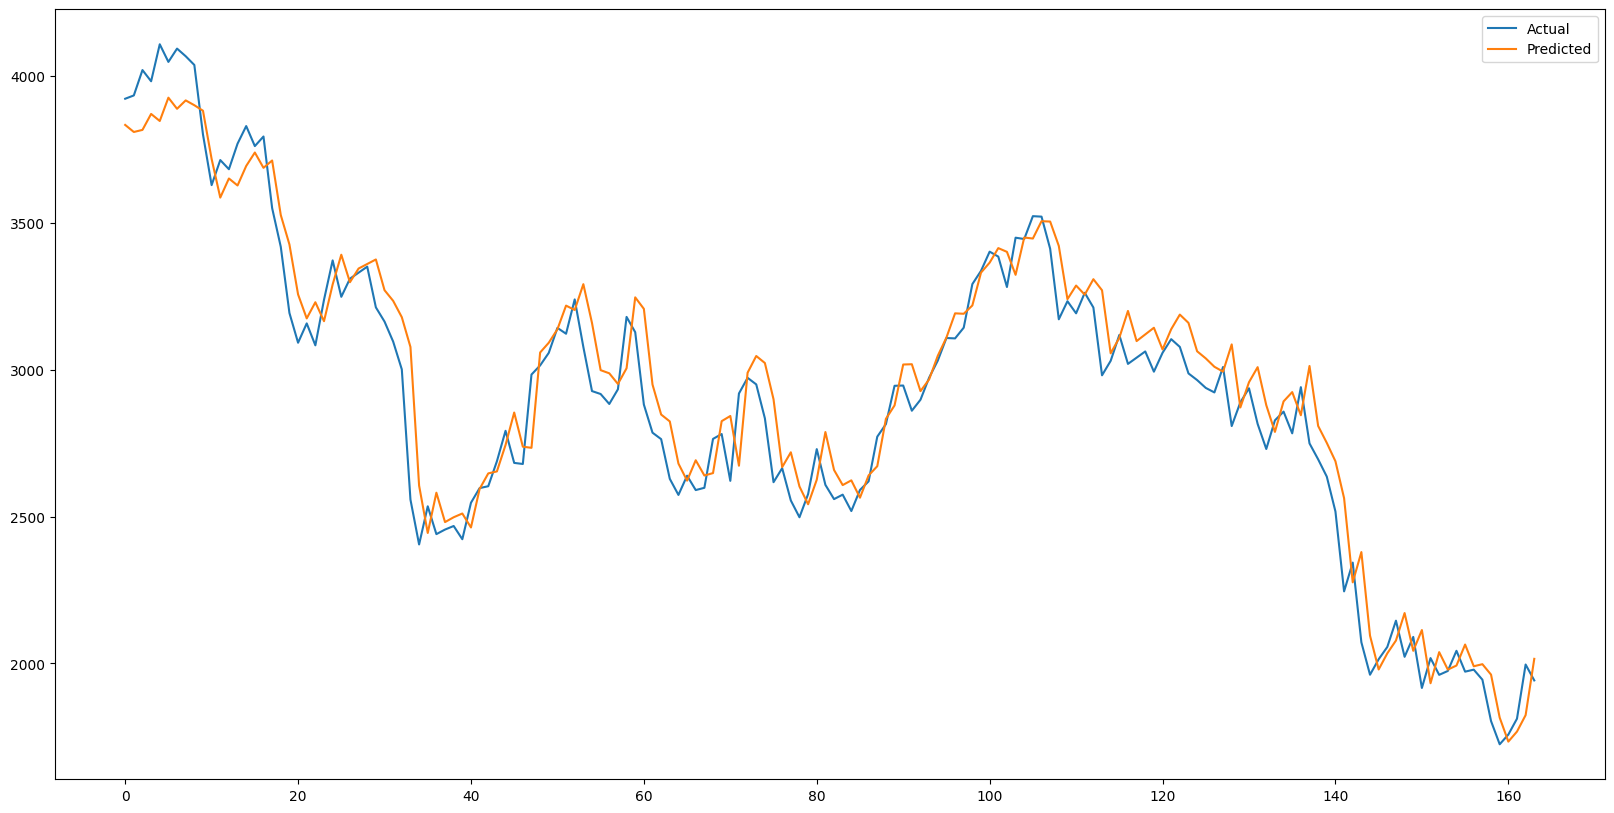

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [19]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_results_unscaled['Actual'] - test_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_results_unscaled['Actual'] - test_results_unscaled['Predicted']))
rmse, mae

(132.07410028191507, 103.06116839153013)

# 3 Day Look Back Window

In [20]:
x_3.shape, y_3.shape

((1662, 3, 1), (1662, 1))

In [21]:
X_3_train, y_3_train = x_3[:0.8*len(x_3)], y_3[:0.8*len(x_3)]
X_3_val, y_3_val = x_3[0.8*len(x_3):0.9*len(x_3)], y_3[0.8*len(x_3):0.9*len(x_3)]
X_3_test, y_3_test = x_3[0.9*len(x_3):], y_3[0.9*len(x_3):]
X_3_train.shape, y_3_train.shape, X_3_val.shape, y_3_val.shape, X_3_test.shape, y_3_test.shape

((1300, 3, 1), (1300, 1), (200, 3, 1), (200, 1), (162, 3, 1), (162, 1))

In [22]:
model_3 = Sequential()
model_3.add(InputLayer(input_shape = (3, 1)))
model_3.add(LSTM(64))
model_3.add(Dense(8, activation = 'relu'))
model_3.add(Dense(1, activation = 'linear'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
cp3 = ModelCheckpoint('models/lstm_3.h5', save_best_only = True)
model_3.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [24]:
model_3.fit(X_3_train, y_3_train, epochs = 200, validation_data = (X_3_val, y_3_val), callbacks = [cp3])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0239 - root_mean_squared_error: 0.1547 - mean_absolute_error: 0.0818 - val_loss: 0.4033 - val_root_mean_squared_error: 0.6350 - val_mean_absolute_error: 0.6115
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - mean_absolute_error: 0.0676 - val_loss: 0.3343 - val_root_mean_squared_error: 0.5781 - val_mean_absolute_error: 0.5550
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - mean_absolute_error: 0.0644 - val_loss: 0.2757 - val_root_mean_squared_error: 0.5251 - val_mean_absolute_error: 0.5024
Epoch 4/200
 1/41 [..............................] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0720 - mean_absolute_error: 0.0473

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - mean_absolute_error: 0.0624 - val_loss: 0.2239 - val_root_mean_squared_error: 0.4731 - val_mean_absolute_error: 0.4510
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977 - mean_absolute_error: 0.0594 - val_loss: 0.1844 - val_root_mean_squared_error: 0.4295 - val_mean_absolute_error: 0.4080
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - mean_absolute_error: 0.0561 - val_loss: 0.1474 - val_root_mean_squared_error: 0.3840 - val_mean_absolute_error: 0.3637
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - mean_absolute_error: 0.0498 - val_loss: 0.1156 - val_root_mean_squared_error: 0.3400 - val_mean_absolute_error: 0.3208
Epoch 8/200
41/41 [==============================] - 0s 2ms/step - loss:

In [25]:
model_3 = load_model('models/lstm_3.h5')

In [26]:
test_3_predictions = model_3.predict(X_3_test)
test_3_results = pd.DataFrame({'Actual': y_3_test.flatten(), 'Predicted': test_3_predictions.flatten()})
test_3_results

6/6 [==============================] - 0s 758us/step


,Actual,Predicted
0,0.832516,0.803943
1,0.824444,0.806486
2,0.851078,0.811030
3,0.838380,0.821541
4,0.847961,0.823933
...,...,...
157,0.347016,0.395516
158,0.354000,0.376366
159,0.365441,0.362035
160,0.404446,0.362498


In [27]:
# Creating a dataframe with the actual and predicted values without the scaling
test_3_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1503:].flatten(), 'Predicted': scaler.inverse_transform(test_3_predictions).flatten()})

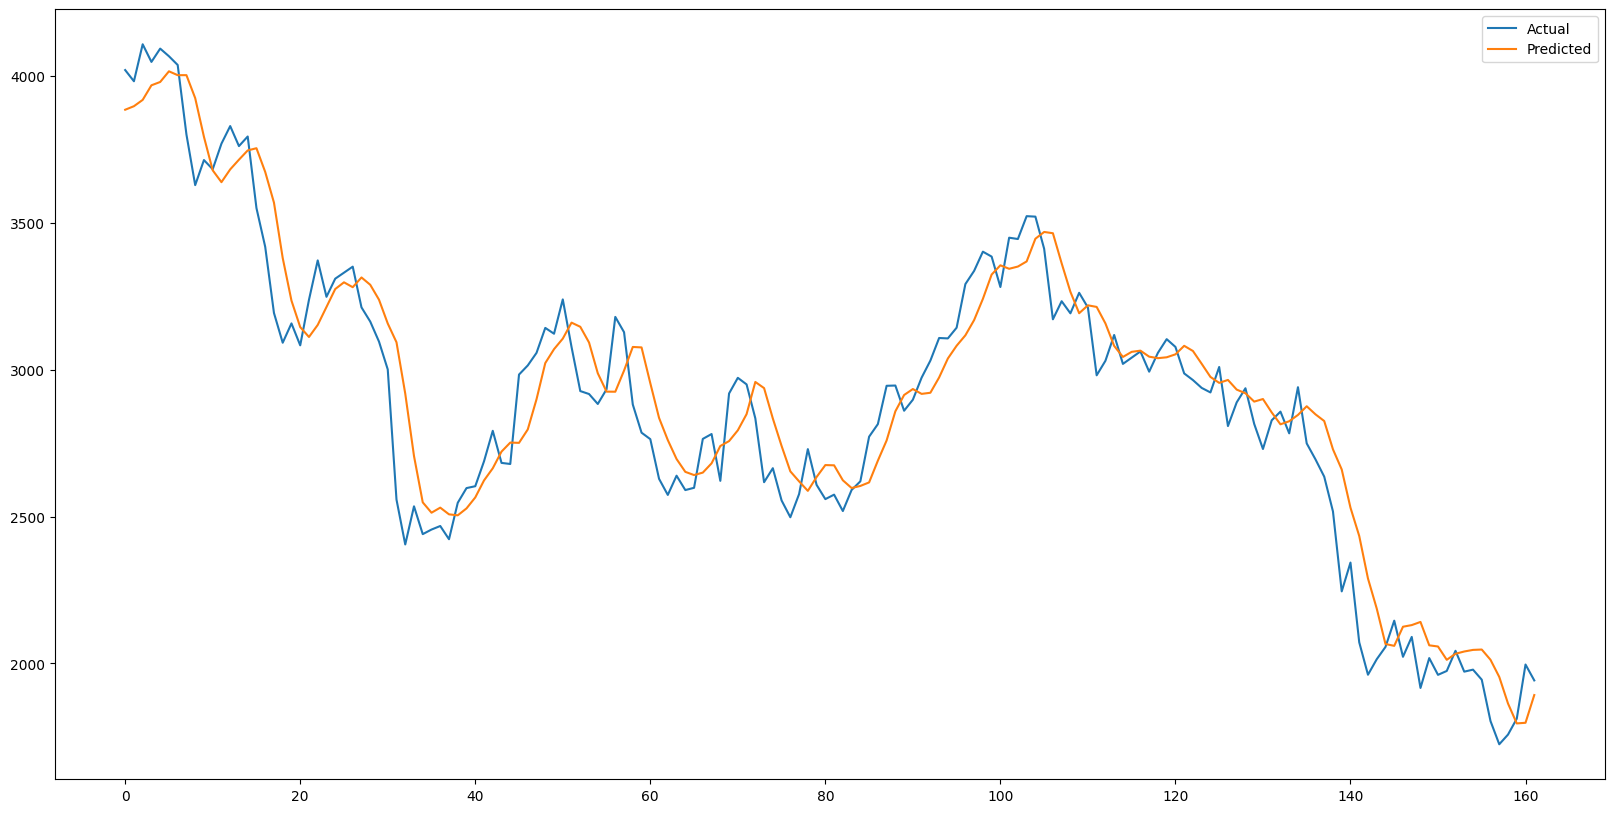

In [28]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_3_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_3_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [29]:
# Calculating the RMSE and MAE
rmse_3 = np.sqrt(np.mean((test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted'])**2))
mae_3 = np.mean(np.abs(test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted']))
rmse_3, mae_3

(152.39831294005106, 121.03200050636575)

# 7 Day Look Back Window

In [30]:
x_7.shape, y_7.shape

((1658, 7, 1), (1658, 1))

In [31]:
X_7_train, y_7_train = x_7[:0.8*len(x_7)], y_7[:0.8*len(x_7)]
X_7_val, y_7_val = x_7[0.8*len(x_7):0.9*len(x_7)], y_7[0.8*len(x_7):0.9*len(x_7)]
X_7_test, y_7_test = x_7[0.9*len(x_7):], y_7[0.9*len(x_7):]
X_7_train.shape, y_7_train.shape, X_7_val.shape, y_7_val.shape, X_7_test.shape, y_7_test.shape

((1300, 7, 1), (1300, 1), (200, 7, 1), (200, 1), (158, 7, 1), (158, 1))

In [32]:
model_7 = Sequential()
model_7.add(InputLayer(input_shape = (7, 1)))
model_7.add(LSTM(64))
model_7.add(Dense(8, activation = 'relu'))
model_7.add(Dense(1, activation = 'linear'))

model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
cp7 = ModelCheckpoint('models/lstm_7.h5', save_best_only = True)
model_7.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [34]:
model_7.fit(X_7_train, y_7_train, epochs = 200, validation_data = (X_7_val, y_7_val), callbacks = [cp7])

Epoch 1/200
41/41 [==============================] - 1s 7ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - mean_absolute_error: 0.0693 - val_loss: 0.2643 - val_root_mean_squared_error: 0.5141 - val_mean_absolute_error: 0.4939
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - mean_absolute_error: 0.0546 - val_loss: 0.1543 - val_root_mean_squared_error: 0.3928 - val_mean_absolute_error: 0.3744
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - mean_absolute_error: 0.0471 - val_loss: 0.0796 - val_root_mean_squared_error: 0.2822 - val_mean_absolute_error: 0.2659
Epoch 4/200
 1/41 [..............................] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0788 - mean_absolute_error: 0.0516

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - mean_absolute_error: 0.0373 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740 - val_mean_absolute_error: 0.1599
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0232 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980 - val_mean_absolute_error: 0.0843
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 5.9102e-04 - root_mean_squared_error: 0.0243 - mean_absolute_error: 0.0128 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.0472
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 4.6241e-04 - root_mean_squared_error: 0.0215 - mean_absolute_error: 0.0094 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.0422
Epoch 8/200
41/41 [==============================] - 0s 2ms/step

In [35]:
model_7 = load_model('models/lstm_7.h5')

In [36]:
test_7_predictions = model_7.predict(X_7_test)
test_7_results = pd.DataFrame({'Actual': y_7_test.flatten(), 'Predicted': test_7_predictions.flatten()})
test_7_results

5/5 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.847961,0.830459
1,0.842472,0.835630
2,0.836173,0.833891
3,0.786116,0.827890
4,0.749659,0.799379
...,...,...
153,0.347016,0.396749
154,0.354000,0.377288
155,0.365441,0.367802
156,0.404446,0.369563


In [37]:
# Creating a dataframe with the actual and predicted values without the scaling
test_7_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1507:].flatten(), 'Predicted': scaler.inverse_transform(test_7_predictions).flatten()})

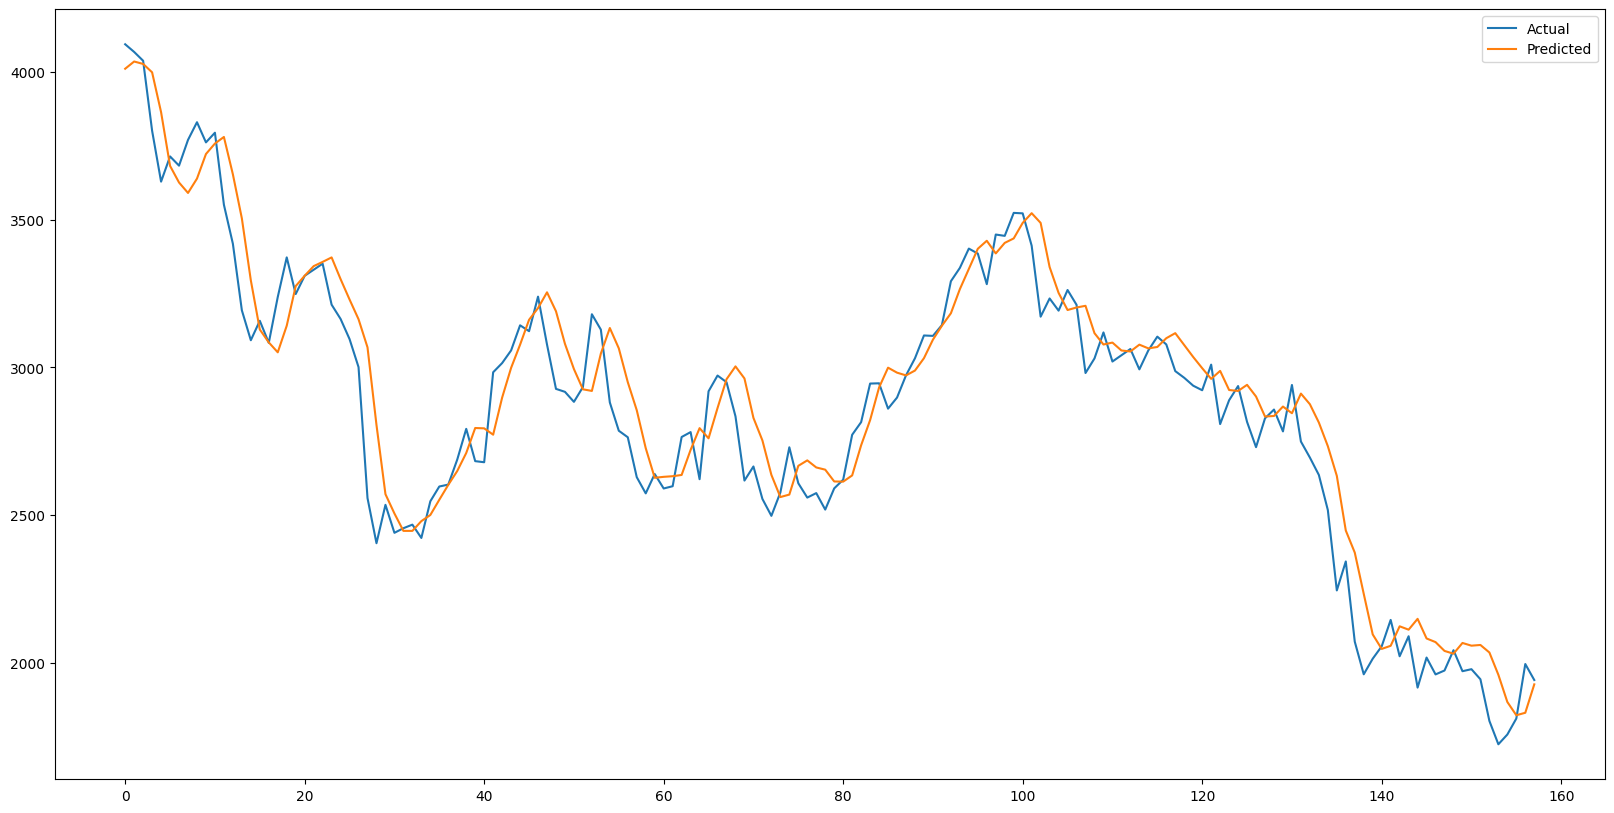

In [38]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_7_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_7_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [39]:
rmse_7 = np.sqrt(np.mean((test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted'])**2))
mae_7 = np.mean(np.abs(test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted']))
rmse_7, mae_7

(142.69030629708942, 108.6423648882516)

# 15 Day Look Back Window

In [40]:
x_15.shape, y_15.shape

((1650, 15, 1), (1650, 1))

In [41]:
X_15_train, y_15_train = x_15[:0.8*len(x_15)], y_15[:0.8*len(x_15)]
X_15_val, y_15_val = x_15[0.8*len(x_15):0.9*len(x_15)], y_15[0.8*len(x_15):0.9*len(x_15)]
X_15_test, y_15_test = x_15[0.9*len(x_15):], y_15[0.9*len(x_15):]
X_15_train.shape, y_15_train.shape, X_15_val.shape, y_15_val.shape, X_15_test.shape, y_15_test.shape

((1300, 15, 1), (1300, 1), (200, 15, 1), (200, 1), (150, 15, 1), (150, 1))

In [42]:
model_15 = Sequential()
model_15.add(InputLayer(input_shape = (15, 1)))
model_15.add(LSTM(64))
model_15.add(Dense(8, activation = 'relu'))
model_15.add(Dense(1, activation = 'linear'))

model_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
cp15 = ModelCheckpoint('models/lstm_15.h5', save_best_only = True)
model_15.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [44]:
model_15.fit(X_15_train, y_15_train, epochs = 200, validation_data = (X_15_val, y_15_val), callbacks = [cp15])

Epoch 1/200
41/41 [==============================] - 1s 8ms/step - loss: 0.0271 - root_mean_squared_error: 0.1645 - mean_absolute_error: 0.0857 - val_loss: 0.4649 - val_root_mean_squared_error: 0.6818 - val_mean_absolute_error: 0.6580
Epoch 2/200
41/41 [==============================] - 0s 4ms/step - loss: 0.0221 - root_mean_squared_error: 0.1487 - mean_absolute_error: 0.0730 - val_loss: 0.4251 - val_root_mean_squared_error: 0.6520 - val_mean_absolute_error: 0.6271
Epoch 3/200
 1/41 [..............................] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1332 - mean_absolute_error: 0.0697

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 3ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - mean_absolute_error: 0.0583 - val_loss: 0.3892 - val_root_mean_squared_error: 0.6238 - val_mean_absolute_error: 0.5977
Epoch 4/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - mean_absolute_error: 0.0485 - val_loss: 0.3570 - val_root_mean_squared_error: 0.5975 - val_mean_absolute_error: 0.5702
Epoch 5/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0135 - root_mean_squared_error: 0.1161 - mean_absolute_error: 0.0439 - val_loss: 0.3287 - val_root_mean_squared_error: 0.5733 - val_mean_absolute_error: 0.5448
Epoch 6/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - mean_absolute_error: 0.0396 - val_loss: 0.3025 - val_root_mean_squared_error: 0.5500 - val_mean_absolute_error: 0.5202
Epoch 7/200
41/41 [==============================] - 0s 3ms/step - loss:

In [45]:
model_15 = load_model('models/lstm_15.h5')

In [46]:
test_15_predictions = model_15.predict(X_15_test)
test_15_results = pd.DataFrame({'Actual': y_15_test.flatten(), 'Predicted': test_15_predictions.flatten()})
test_15_results

5/5 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.792181,0.765651
1,0.777759,0.782540
2,0.784670,0.774076
3,0.733130,0.777144
4,0.705215,0.733738
...,...,...
145,0.347016,0.381710
146,0.354000,0.361180
147,0.365441,0.364197
148,0.404446,0.376392


In [47]:
# Creating a dataframe with the actual and predicted values without the scaling
test_15_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1515:].flatten(), 'Predicted': scaler.inverse_transform(test_15_predictions).flatten()})

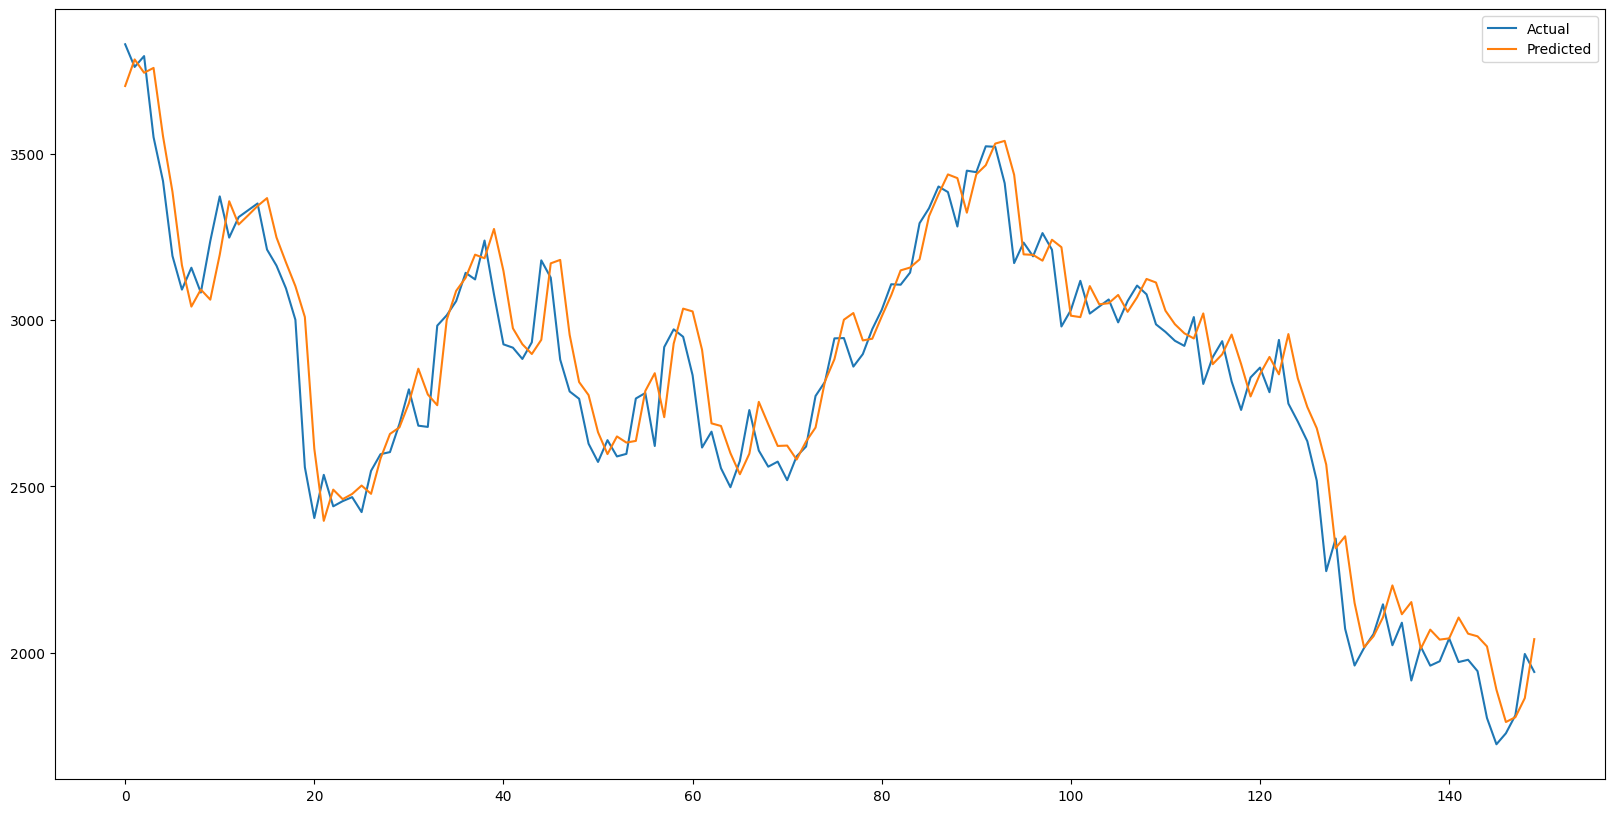

In [48]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_15_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_15_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [49]:
rmse_15 = np.sqrt(np.mean((test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted'])**2))
mae_15 = np.mean(np.abs(test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted']))
rmse_15, mae_15

(123.28410331649273, 93.44158203125002)

# 30 Day Look Back Window

In [50]:
x_30.shape, y_30.shape

((1635, 30, 1), (1635, 1))

In [51]:
X_30_train, y_30_train = x_30[:0.8*len(x_30)], y_30[:0.8*len(x_30)]
X_30_val, y_30_val = x_30[0.8*len(x_30):0.9*len(x_30)], y_30[0.8*len(x_30):0.9*len(x_30)]
X_30_test, y_30_test = x_30[0.9*len(x_30):], y_30[0.9*len(x_30):]
X_30_train.shape, y_30_train.shape, X_30_val.shape, y_30_val.shape, X_30_test.shape, y_30_test.shape

((1300, 30, 1), (1300, 1), (200, 30, 1), (200, 1), (135, 30, 1), (135, 1))

In [52]:
model_30 = Sequential()
model_30.add(InputLayer(input_shape = (30, 1)))
model_30.add(LSTM(64))
model_30.add(Dense(8, activation = 'relu'))
model_30.add(Dense(1, activation = 'linear'))

model_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
cp30 = ModelCheckpoint('models/lstm_30.h5', save_best_only = True)
model_30.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [54]:
model_30.fit(X_30_train, y_30_train, epochs = 200, validation_data = (X_30_val, y_30_val), callbacks = [cp30])

Epoch 1/200
41/41 [==============================] - 1s 10ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - mean_absolute_error: 0.0601 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1042 - val_mean_absolute_error: 0.0847
Epoch 2/200
28/41 [===================>..........] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0210

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 6ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0195 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1363 - val_mean_absolute_error: 0.1178
Epoch 3/200
41/41 [==============================] - 0s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - mean_absolute_error: 0.0162 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0720
Epoch 4/200
41/41 [==============================] - 0s 6ms/step - loss: 9.3112e-04 - root_mean_squared_error: 0.0305 - mean_absolute_error: 0.0151 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918 - val_mean_absolute_error: 0.0760
Epoch 5/200
41/41 [==============================] - 0s 6ms/step - loss: 8.8990e-04 - root_mean_squared_error: 0.0298 - mean_absolute_error: 0.0153 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1294 - val_mean_absolute_error: 0.1131
Epoch 6/200
41/41 [==============================] - 0s 7ms/step

In [55]:
model_30 = load_model('models/lstm_30.h5')

In [56]:
test_30_predictions = model_30.predict(X_30_test)
test_30_results = pd.DataFrame({'Actual': y_30_test.flatten(), 'Predicted': test_30_predictions.flatten()})
test_30_results

5/5 [==============================] - 0s 2ms/step


,Actual,Predicted
0,0.661621,0.700337
1,0.651409,0.681024
2,0.636984,0.664298
3,0.616952,0.648870
4,0.523210,0.629004
...,...,...
130,0.347016,0.379728
131,0.354000,0.358745
132,0.365441,0.355452
133,0.404446,0.363260


In [57]:
# Creating a dataframe with the actual and predicted values without the scaling
test_30_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1530:].flatten(), 'Predicted': scaler.inverse_transform(test_30_predictions).flatten()})

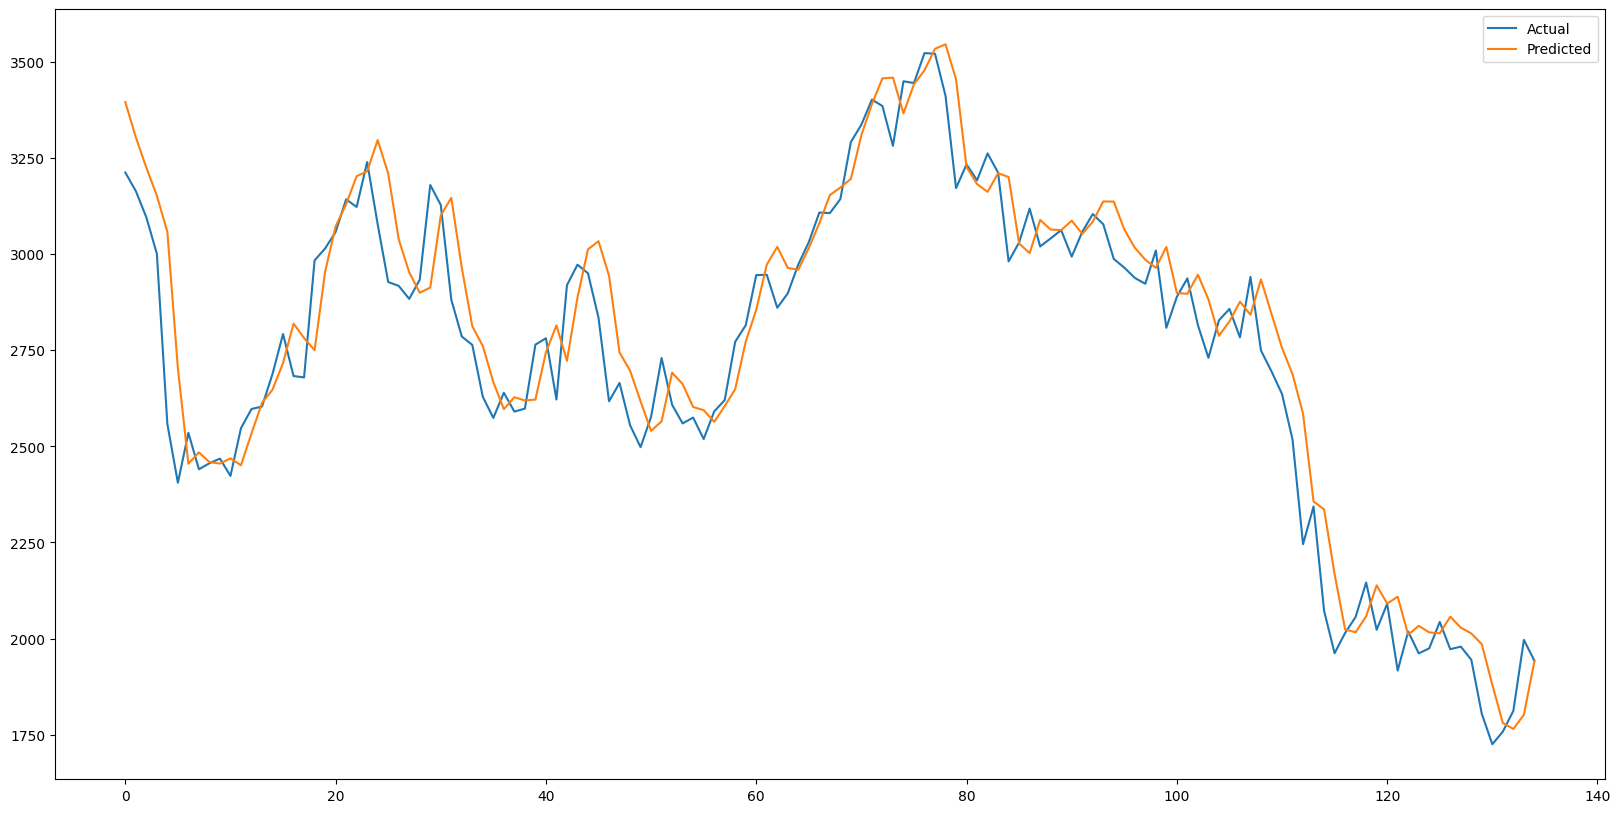

In [58]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_30_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_30_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [59]:
rmse_30 = np.sqrt(np.mean((test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted'])**2))
mae_30 = np.mean(np.abs(test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted']))
rmse_30, mae_30

(128.31534878334577, 95.50407443576391)

# 60 Day Look Back Window

In [60]:
x_60.shape, y_60.shape

((1605, 60, 1), (1605, 1))

In [61]:
X_60_train, y_60_train = x_60[:0.8*len(x_60)], y_60[:0.8*len(x_60)]
X_60_val, y_60_val = x_60[0.8*len(x_60):0.9*len(x_60)], y_60[0.8*len(x_60):0.9*len(x_60)]
X_60_test, y_60_test = x_60[0.9*len(x_60):], y_60[0.9*len(x_60):]
X_60_train.shape, y_60_train.shape, X_60_val.shape, y_60_val.shape, X_60_test.shape, y_60_test.shape

((1300, 60, 1), (1300, 1), (200, 60, 1), (200, 1), (105, 60, 1), (105, 1))

In [62]:
model_60 = Sequential()
model_60.add(InputLayer(input_shape = (60, 1)))
model_60.add(LSTM(64))
model_60.add(Dense(8, activation = 'relu'))
model_60.add(Dense(1, activation = 'linear'))

model_60.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
cp60 = ModelCheckpoint('models/lstm_60.h5', save_best_only = True)
model_60.compile(optimizer = Adam(learning_rate = 0.001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [64]:
model_60.fit(X_60_train, y_60_train, epochs = 200, validation_data = (X_60_val, y_60_val), callbacks = [cp60])

Epoch 1/200
41/41 [==============================] - 1s 16ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0335 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.0545
Epoch 2/200
18/41 [============>.................] - ETA: 0s - loss: 5.6353e-04 - root_mean_squared_error: 0.0237 - mean_absolute_error: 0.0127

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 11ms/step - loss: 7.6703e-04 - root_mean_squared_error: 0.0277 - mean_absolute_error: 0.0137 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714 - val_mean_absolute_error: 0.0604
Epoch 3/200
41/41 [==============================] - 1s 12ms/step - loss: 7.0634e-04 - root_mean_squared_error: 0.0266 - mean_absolute_error: 0.0150 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.0403
Epoch 4/200
41/41 [==============================] - 1s 13ms/step - loss: 5.3650e-04 - root_mean_squared_error: 0.0232 - mean_absolute_error: 0.0120 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668 - val_mean_absolute_error: 0.0570
Epoch 5/200
41/41 [==============================] - 1s 12ms/step - loss: 5.1866e-04 - root_mean_squared_error: 0.0228 - mean_absolute_error: 0.0120 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693 - val_mean_absolute_error: 0.0594
Epoch 6/200
41/41 [==============================] -

In [65]:
model_60 = load_model('models/lstm_60.h5')

In [66]:
test_60_predictions = model_60.predict(X_60_test)
test_60_results = pd.DataFrame({'Actual': y_60_test.flatten(), 'Predicted': test_60_predictions.flatten()})

4/4 [==============================] - 0s 3ms/step


In [67]:
# Creating a dataframe with the actual and predicted values without the scaling
test_60_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1560:].flatten(), 'Predicted': scaler.inverse_transform(test_60_predictions).flatten()})
test_60_results_unscaled

,Actual,Predicted
0,3127.830078,3068.100098
1,2881.481934,3106.182861
2,2785.727539,2937.842285
3,2763.701172,2815.559326
4,2628.648438,2766.978760
...,...,...
100,1724.922852,1838.962646
101,1757.941772,1743.586792
102,1812.031006,1742.247314
103,1996.441284,1787.457275


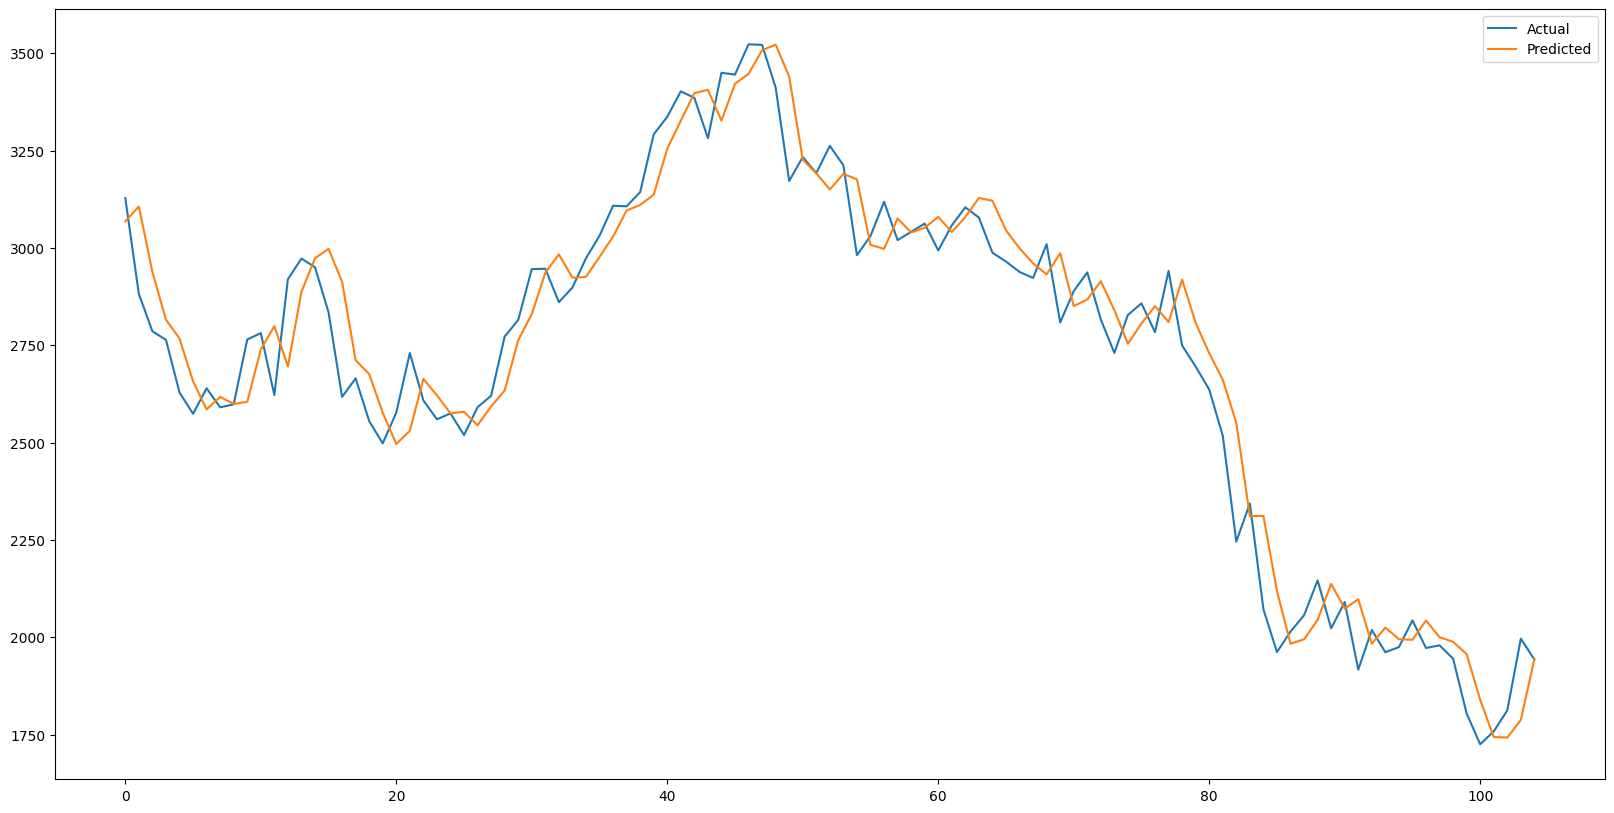

In [68]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_60_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_60_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [69]:
rmse_60 = np.sqrt(np.mean((test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted'])**2))
mae_60 = np.mean(np.abs(test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted']))
rmse_60, mae_60

(109.42630996808909, 86.16296735491075)

# Comparing the models 

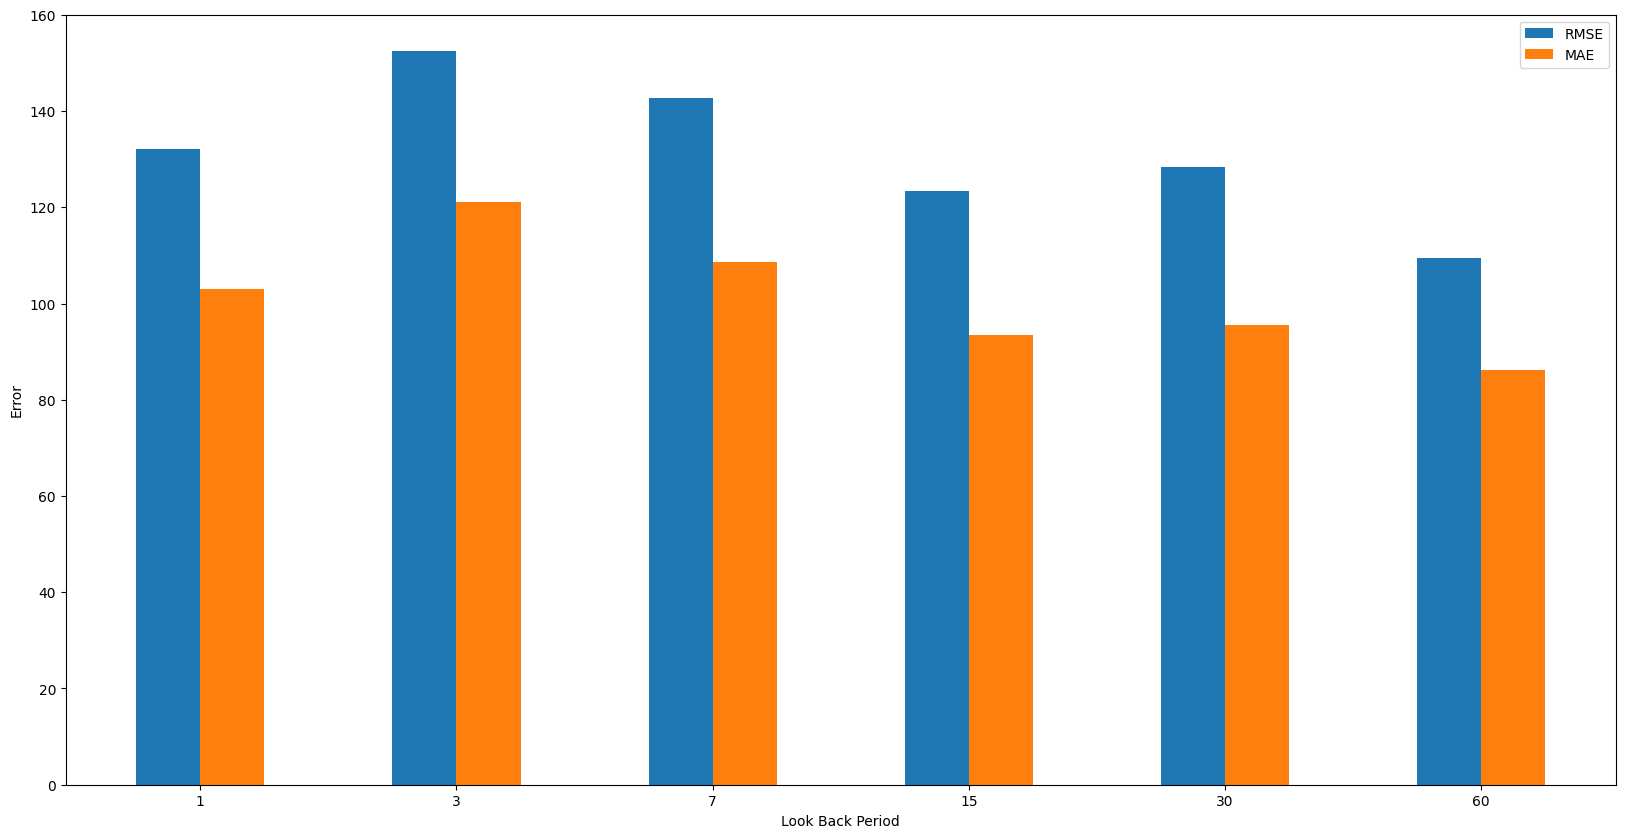

In [70]:
# Plotting in a bar chart, the RMSE and MAE for each look back period. The two metrics are plotted side by side for each look back period
plt.figure(figsize = (20, 10))
plt.bar(np.arange(6), [rmse, rmse_3, rmse_7, rmse_15, rmse_30, rmse_60], width = 0.25, label = 'RMSE')
plt.bar(np.arange(6) + 0.25, [mae, mae_3, mae_7, mae_15, mae_30, mae_60], width = 0.25, label = 'MAE')
plt.xticks(np.arange(6) + 0.125, ['1', '3', '7', '15', '30', '60'])
plt.xlabel('Look Back Period')
plt.ylabel('Error')
plt.legend()